In [1]:
from pathlib import Path
import networkx as nx
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import pickle as pk
import numpy as np
import pandas as pd
from datetime import datetime as dt
from geopy.distance import great_circle
import matplotlib.pyplot as plt
from random import choices
import itertools
from multiprocessing import Pool
import geopandas as gpd
import time
import gc
import bisect
import sys
sys.path.append("/")
import homophily_functions as fn


%matplotlib inline



In [2]:
tracts = gpd.read_file("../Aux_Data/Tract_2010Census_DP1/Tract_2010Census_DP1.shp")
tracts = tracts.to_crs('ESRI:102003')
tracts = tracts[["GEOID10", "DP0010001", "geometry"]]

# Diameter of Circles with given population

In [3]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pandas as pd

def find_population_circle(gdf, center_point, target_population=100000,
                           min_radius = 100, max_radius = 100000, error_margin = 0.01):
    """
    Find a circle around a center point that contains approximately the target population.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame containing census tracts with population data
    center_point : Point
        The center point to build the circle around
    target_population : int
        Target population to include in the circle
        
    Returns:
    --------
    radius : float
        Radius in meters
    population : int
        Actual population within the circle
    """
    # Binary search to find the right radius
    
    # Function to calculate population within radius
    def population_within_radius(radius):
        buffer = center_point.buffer(radius)
        # Find all tracts that intersect with the buffer
        tracts_in_radius = gdf[gdf.intersects(buffer)]
        # Calculate total population
        total_pop = tracts_in_radius['DP0010001'].sum()  # Adjust column name as needed
        return total_pop, tracts_in_radius
    
    # Binary search
    current_radius = (min_radius + max_radius) / 2
    iterations = 0
    max_iterations = 50
    best_radius = current_radius
    best_pop = 0
    
    while iterations < max_iterations:
        pop, _ = population_within_radius(current_radius)
        print(f"Iteration {iterations}: Radius = {current_radius/1000:.2f} km, Population = {pop}")
        
        # Check if we're close enough
        if abs(pop - target_population) < target_population * error_margin:  # Within 5%
            best_radius = current_radius
            best_pop = pop
            break
            
        # Update best estimate so far
        if best_pop == 0 or abs(pop - target_population) < abs(best_pop - target_population):
            best_radius = current_radius
            best_pop = pop
        
        # Adjust radius
        if pop < target_population:
            min_radius = current_radius
        else:
            max_radius = current_radius
            
        current_radius = (min_radius + max_radius) / 2
        iterations += 1
    
    return best_radius, best_pop


In [4]:
esb_point = Point(-73.9857, 40.7484)
esb_point_projected = gpd.GeoDataFrame(geometry=[esb_point], crs='EPSG:4326').to_crs(tracts.crs)
esb_center = esb_point_projected.geometry.iloc[0]


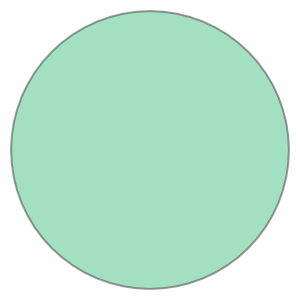

In [9]:
esb_center.buffer(1000)

In [5]:
# Identify Helena, MT center
helena_point = Point(-112.0391, 46.5891)
helena_point_projected = gpd.GeoDataFrame(geometry=[helena_point], crs="EPSG:4326").to_crs(tracts.crs)
helena_center = helena_point_projected.geometry.iloc[0]

In [6]:
# Find radii for both locations
print("Finding circle for Manhattan (Empire State Building):")
manhattan_radius, manhattan_pop = find_population_circle(tracts, esb_center, target_population = 500000, error_margin = 0.003)

Finding circle for Manhattan (Empire State Building):
Iteration 0: Radius = 50.05 km, Population = 15640058
Iteration 1: Radius = 25.07 km, Population = 11159439
Iteration 2: Radius = 12.59 km, Population = 5211696
Iteration 3: Radius = 6.34 km, Population = 1943220
Iteration 4: Radius = 3.22 km, Population = 658306
Iteration 5: Radius = 1.66 km, Population = 282270
Iteration 6: Radius = 2.44 km, Population = 455599
Iteration 7: Radius = 2.83 km, Population = 545592
Iteration 8: Radius = 2.64 km, Population = 505351
Iteration 9: Radius = 2.54 km, Population = 482844
Iteration 10: Radius = 2.59 km, Population = 505351
Iteration 11: Radius = 2.56 km, Population = 491611
Iteration 12: Radius = 2.58 km, Population = 505351
Iteration 13: Radius = 2.57 km, Population = 499917


In [42]:
print("\nFinding circle for Helena, Montana:")
helena_radius, helena_pop = find_population_circle(tracts, helena_center, target_population = 500000, max_radius = 500000, error_margin = 0.003)



Finding circle for Helena, Montana:
Iteration 0: Radius = 250.05 km, Population = 711101
Iteration 1: Radius = 125.08 km, Population = 313054
Iteration 2: Radius = 187.56 km, Population = 559702
Iteration 3: Radius = 156.32 km, Population = 480681
Iteration 4: Radius = 171.94 km, Population = 533914
Iteration 5: Radius = 164.13 km, Population = 515254
Iteration 6: Radius = 160.22 km, Population = 498664


In [7]:
160.22/2.57

62.342412451361874

Using state boundaries derived from GEOID10


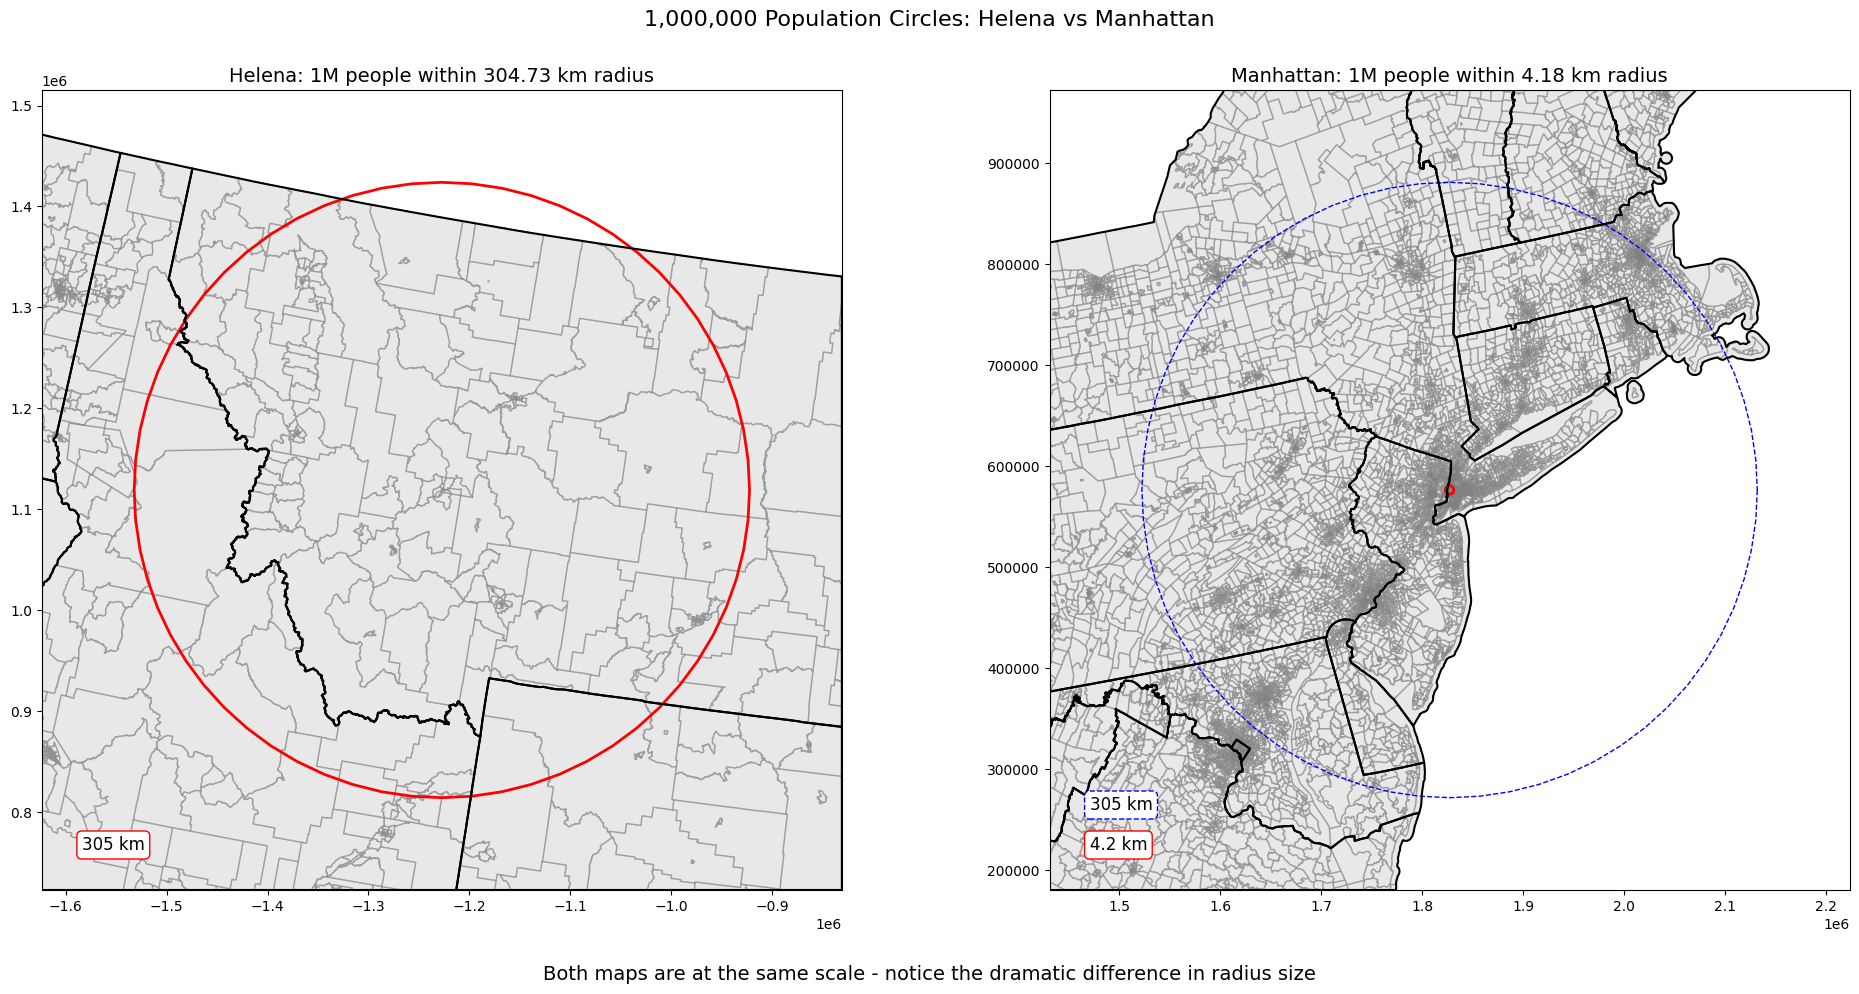

In [38]:

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box

# Set zoom level - higher value = more zoomed out
zoom_factor = 1.3  # Double the view area beyond the circles

# Calculate view extents with consistent dimensions
manhattan_x, manhattan_y = esb_center.x, esb_center.y
helena_x, helena_y = helena_center.x, helena_center.y

# Use the larger radius (Helena) to determine view extent
extent_radius = helena_radius * zoom_factor

# Create identical sized bounding boxes centered on each point
manhattan_bounds = (
    manhattan_x - extent_radius,  # min x
    manhattan_y - extent_radius,  # min y
    manhattan_x + extent_radius,  # max x
    manhattan_y + extent_radius   # max y
)

helena_bounds = (
    helena_x - extent_radius,  # min x
    helena_y - extent_radius,  # min y
    helena_x + extent_radius,  # max x
    helena_y + extent_radius   # max y
)

# Create bounding boxes for clipping
manhattan_box = box(*manhattan_bounds)
helena_box = box(*helena_bounds)

# Clip the tracts to these areas for faster plotting
manhattan_area_tracts = tracts[tracts.intersects(manhattan_box)]
helena_area_tracts = tracts[tracts.intersects(helena_box)]

# Create state boundaries from GEOID10 column (first 2 digits are state FIPS code)
try:
    # Extract state FIPS code from GEOID10 (first 2 digits)
    if 'GEOID10' in tracts.columns:
        # Create a temporary state column
        tracts_temp = tracts.copy()
        tracts_temp['STATE_FIPS'] = tracts_temp['GEOID10'].str[:2]
        
        # Group by state to create state boundaries
        all_states = tracts_temp.dissolve(by='STATE_FIPS')
        
        # Clip to our areas of interest
        manhattan_box_gdf = gpd.GeoDataFrame(geometry=[manhattan_box], crs=tracts.crs)
        helena_box_gdf = gpd.GeoDataFrame(geometry=[helena_box], crs=tracts.crs)
        
        manhattan_area_states = gpd.overlay(all_states, manhattan_box_gdf, how='intersection')
        helena_area_states = gpd.overlay(all_states, helena_box_gdf, how='intersection')
        
        has_state_boundaries = True
        print("Using state boundaries derived from GEOID10")
    else:
        has_state_boundaries = False
        print("No GEOID10 column found in tract data")
except Exception as e:
    print(f"Could not create state boundaries: {e}")
    has_state_boundaries = False

# Create the figure and axes with equal scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('1,000,000 Population Circles: Helena vs Manhattan', fontsize=16)

# Plot Helena
helena_area_tracts.plot(ax=ax1, color='lightgrey', edgecolor='grey', alpha=0.5)
gpd.GeoDataFrame(geometry=[helena_center.buffer(helena_radius)], crs=tracts.crs).plot(
    ax=ax1, color='none', edgecolor='red', linewidth=2)

# Plot Manhattan
manhattan_area_tracts.plot(ax=ax2, color='lightgrey', edgecolor='grey', alpha=0.5)
gpd.GeoDataFrame(geometry=[esb_center.buffer(helena_radius)], crs=tracts.crs).plot(
    ax=ax2, color='none', edgecolor='blue', linewidth=1, linestyle='--')
gpd.GeoDataFrame(geometry=[esb_center.buffer(manhattan_radius)], crs=tracts.crs).plot(
    ax=ax2, color='none', edgecolor='red', linewidth=2)

# Add state boundaries if available
if has_state_boundaries:
    helena_area_states.boundary.plot(ax=ax1, color='black', linewidth=1.5)
    manhattan_area_states.boundary.plot(ax=ax2, color='black', linewidth=1.5)

# Add titles
ax1.set_title(f"Helena: 1M people within {helena_radius/1000:.2f} km radius", fontsize=14)
ax2.set_title(f"Manhattan: 1M people within {manhattan_radius/1000:.2f} km radius", fontsize=14)

# Add scale indicators and annotations
ax1.annotate(f"{helena_radius/1000:.0f} km", xy=(0.05, 0.05), xycoords='axes fraction',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red"))
ax2.annotate(f"{manhattan_radius/1000:.1f} km", xy=(0.05, 0.05), xycoords='axes fraction',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red"))
ax2.annotate(f"{helena_radius/1000:.0f} km", xy=(0.05, 0.1), xycoords='axes fraction',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", linestyle='--'))

# Set equal aspect ratios
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Explicitly set the plot limits to ensure they're at the same scale
ax1.set_xlim(helena_bounds[0], helena_bounds[2])
ax1.set_ylim(helena_bounds[1], helena_bounds[3])
ax2.set_xlim(manhattan_bounds[0], manhattan_bounds[2])
ax2.set_ylim(manhattan_bounds[1], manhattan_bounds[3])

# Add a note about scale
fig.text(0.5, 0.01, 'Both maps are at the same scale - notice the dramatic difference in radius size',
         fontsize=14, ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)

# Save the figure
plt.savefig("population_comparison.png", dpi=300, bbox_inches='tight')



# Density of ties in each area

In [3]:
G = pk.load(open("../Pickles/follower_graph.pk", "rb"))    

In [4]:
all_nodes = {n for n in G.nodes() if 'lat' in G.nodes[n] and 'lon' in G.nodes[n]}
nodes = [(G.nodes[n]["lat"], G.nodes[n]["lon"]) for n in all_nodes]

In [20]:
import networkx as nx
import numpy as np
import pandas as pd
from math import radians, cos, sin, asin, sqrt
import multiprocessing as mp
from functools import partial
import time

def is_node_in_circle(node_info, center_lon, center_lat, radius_meters):
    """Check if a single node is within the circle - one node per worker"""
    node_id, lat, lon = node_info

    # Skip if node doesn't have location data
    if pd.isna(lat) or pd.isna(lon):
        return None
    
    # Calculate distance
    coord1 = (lat, lon)
    coord2 = (center_lat, center_lon)
    dist = great_circle(coord1, coord2).meters
    if dist <= radius_meters:
        return node_id
    return None

def find_nodes_in_circle_parallel(G, center_lon, center_lat, radius_meters, n_jobs):
    """Simple process-per-node approach for better parallelization"""
    
    # Get all nodes with location data and their coordinates
    all_nodes = []
    for n in G.nodes():
        if 'lat' in G.nodes[n] and 'lon' in G.nodes[n]:
            all_nodes.append((n, G.nodes[n]['lat'], G.nodes[n]['lon']))  # Include node ID
            
    #print(f"Total nodes with location data: {len(all_nodes):,}")
    
    # Use specified number of processors
    n_processes = n_jobs
    #print(f"Using {n_processes} processes for parallel computation")
    
    # Create a partial function for use with Pool
    func = partial(is_node_in_circle, 
                 center_lon=center_lon, 
                 center_lat=center_lat, 
                 radius_meters=radius_meters)
    
    # Create pool and process directly
    start_time = time.time()
    with mp.Pool(processes=n_processes) as pool:
        # Use pool.map directly - simpler approach
        results = pool.map(func, all_nodes, chunksize=1000)  # Using larger chunksize for efficiency
    
    elapsed = time.time() - start_time
    
    # Filter out None results
    nodes_in_circle = [node for node in results if node is not None]
    #print(f"Processed {len(all_nodes):,} nodes in {elapsed:.2f} seconds")
    
    return nodes_in_circle

def calculate_network_density_in_circle(G, center_lon, center_lat, radius_meters, n_jobs):
    """Calculate network density with simplified parallelization"""
    #print(f"Finding nodes within {radius_meters/1000:.1f}km of ({center_lon:.4f}, {center_lat:.4f})...")
    
    nodes_in_circle = find_nodes_in_circle_parallel(G, center_lon, center_lat, radius_meters, n_jobs)
    #print(f"Found {len(nodes_in_circle):,} nodes in circle")
    
    # Extract the subgraph for these nodes
    if len(nodes_in_circle) > 1:
        #print("Creating subgraph...")
        subgraph = G.subgraph(nodes_in_circle)
        
        # Calculate density
        n = subgraph.number_of_nodes()
        m = subgraph.number_of_edges()
        
        # For directed graphs, max possible edges is n*(n-1)
        # For undirected graphs, max possible edges is n*(n-1)/2
        if nx.is_directed(G):
            max_possible_edges = n * (n - 1)
        else:
            max_possible_edges = n * (n - 1) / 2
        
        if max_possible_edges > 0:
            density = m / max_possible_edges
        else:
            density = 0
            
        return density, n, m
    else:
        return 0, len(nodes_in_circle), 0

def analyze_network_density_simple(G, manhattan_coords, helena_coords, radius=100000, n_jobs=4):
    """Network density analysis with simplified parallelization"""
    # Unpack coordinates
    manhattan_lat, manhattan_lon = manhattan_coords
    helena_lat, helena_lon = helena_coords
    
    # Calculate density for Manhattan
    #print("\n==== Analyzing Manhattan ====")
    manhattan_density, manhattan_nodes, manhattan_edges = calculate_network_density_in_circle(
        G, manhattan_lon, manhattan_lat, radius, n_jobs
    )
    
    # Calculate density for Helena
    #print("\n==== Analyzing Helena ====")
    helena_density, helena_nodes, helena_edges = calculate_network_density_in_circle(
        G, helena_lon, helena_lat, radius, n_jobs
    )
    
    # Print results
    print("\n==== Results ====")
    print(f"Network density analysis with {radius/1000:.0f}km radius:")
    print(f"Manhattan: {manhattan_density:.6f} density with {manhattan_nodes:,} nodes and {manhattan_edges:,} edges")
    print(f"Helena: {helena_density:.6f} density with {helena_nodes:,} nodes and {helena_edges:,} edges")
    
    ratio = "N/A"
    if helena_density > 0:
        ratio = f"{helena_density/manhattan_density:.2f}"
    
    print(f"Ratio: Helena/Manhattan density ratio is {ratio}")
    
    return {
        'manhattan': {
            'density': manhattan_density,
            'nodes': manhattan_nodes,
            'edges': manhattan_edges
        },
        'helena': {
            'density': helena_density,
            'nodes': helena_nodes,
            'edges': helena_edges
        },
        'radius_km': radius/1000
    }

In [43]:
#Define the coordinates (lat, lon)
esb_coords = (40.7484, -73.9857)  # (lat, lon) for Empire State Building
helena_coords = (46.5891, -112.0370)  # (lat, lon) for Helena, MT

# Run the analysis
result = analyze_network_density_simple(G, esb_coords, helena_coords, radius=160000, n_jobs=8)



==== Results ====
Network density analysis with 160km radius:
Manhattan: 0.000092 density with 105,356 nodes and 1,019,407 edges
Helena: 0.002124 density with 1,777 nodes and 6,703 edges
Ratio: Helena/Manhattan density ratio is 23.13


In [40]:
nx.density(G)

1.587767068814002e-05

In [15]:
0.007895/0.000129

61.201550387596896

In [21]:

# Or analyze multiple radii with progress tracking
radii = [50000, 100000, 150000, 200000, 300000]

for rad in radii:
    analyze_network_density_simple(G, esb_coords, helena_coords, radius=rad, n_jobs=8)



==== Results ====
Network density analysis with 50km radius:
Manhattan: 0.000178 density with 60,958 nodes and 661,499 edges
Helena: 0.006651 density with 237 nodes and 372 edges
Ratio: Helena/Manhattan density ratio is 37.36

==== Results ====
Network density analysis with 100km radius:
Manhattan: 0.000129 density with 78,860 nodes and 800,979 edges
Helena: 0.007895 density with 408 nodes and 1,311 edges
Ratio: Helena/Manhattan density ratio is 61.30

==== Results ====
Network density analysis with 150km radius:
Manhattan: 0.000095 density with 102,483 nodes and 994,756 edges
Helena: 0.002709 density with 1,184 nodes and 3,795 edges
Ratio: Helena/Manhattan density ratio is 28.61

==== Results ====
Network density analysis with 200km radius:
Manhattan: 0.000082 density with 114,517 nodes and 1,076,086 edges
Helena: 0.001976 density with 1,950 nodes and 7,509 edges
Ratio: Helena/Manhattan density ratio is 24.08

==== Results ====
Network density analysis with 300km radius:
Manhattan: 0

In [ ]:

# For multiple radii, you can still use a loop
radii = [50000, 100000, 200000, 300000, 400000, 500000]
results = []

# Only build the spatial index once
print("Preparing spatial index...")
spatial_idx, node_points = prepare_spatial_index(G, "ESRI:102003")

for radius in radii:
    print(f"Analyzing radius {radius/1000:.0f}km...")
    # Pass the prebuilt spatial index
    results.append({
        'radius': radius,
        'manhattan': calculate_network_density_in_circle(G, esb_center, radius, spatial_idx, node_points, n_cores),
        'helena': calculate_network_density_in_circle(G, helena_center, radius, spatial_idx, node_points, n_cores)
    })

In [ ]:

# For comparing multiple radii:
summary_table = compare_multiple_radii(G, esb_center, helena_center)
print(summary_table)